In [2]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
import os
import SimpleITK as sitk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from image_utils import convert_series_to_nifti, quantize_maps, quantize_maps_top_quarter, clear_directory, convert_and_copy_with_labels_and_rename, generate_dataset_json
import logging
from image_utils import ImageVisualizer, show_progress
from skimage.restoration import inpaint

#DATASET_NUM = "041"
FOLD_NUM = 0

In [ ]:
input_folder = r'D:\CTH_archive\CTA_NIFTI'
stripped_folder = r'D:\CTH_archive\CTA_STRIPPED_MASK'
output_folder = r'D:\CTH_archive\CTA_STRIPPED'


os.makedirs(stripped_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# Skull stripping process
for filename in os.listdir(input_folder):
    if filename.endswith(('.nii')):
        patient_name = filename.split(' ')[0]  # Extract patient name
        input_path = os.path.join(input_folder, filename)
        stripped_path = os.path.join(stripped_folder, patient_name)

        # Check if the stripped file already exists
        if not os.path.exists(stripped_path):
            try:
                input_img = nib.load(input_path)
                totalsegmentator(input_img, stripped_path, roi_subset=['brain'], ml=True)
                print(f"Processed and saved: {stripped_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")
        else:
            print(f"Stripped file already exists, skipping: {stripped_path}")

# Applying masks to stripped images
missing_files = []

for mask_filename in tqdm(os.listdir(stripped_folder)):
    base_filename = os.path.splitext(mask_filename)[0].rsplit('.', 1)[0]  # Handle potential double extensions
    original_path = None

    # Find matching original file
    for original_filename in os.listdir(input_folder):
        if os.path.splitext(original_filename)[0].rsplit('.', 1)[0] == base_filename:
            original_path = os.path.join(input_folder, original_filename)
            break

    if original_path:
        mask_path = os.path.join(stripped_folder, mask_filename)

        output_filename = base_filename
        output_path = os.path.join(output_folder, output_filename)

        if not os.path.exists(output_path):
            print(f"Applying mask to {original_path} using {mask_path}")

            # Load and apply mask
            mask_nii = nib.load(mask_path)
            original_nii = nib.load(original_path)
            masked_data = np.where(mask_nii.get_fdata() > 0, original_nii.get_fdata(), 0)
            masked_nii = nib.Nifti1Image(masked_data, affine=original_nii.affine)

            nib.save(masked_nii, output_path)

        else:
            print(f"Masked file already exists, skipping: {output_path}")
    else:
        print(f"No matching file found for {mask_filename} in {input_folder}")
        missing_files.append((mask_filename, input_folder))

print("Mask application complete.")
if missing_files:
    print("Missing files:", missing_files)


In [6]:
transforms_dir = "D:/CTH_archive/CBF_TRANSFORMS"
fixed_images_dir = "D:/CTH_archive/CTA_STRIPPED"  
moving_images_dir = "D:/CTH_archive/CTP_STRIPPED" 
transformed_img_dir = "D:/CTH_archive/CTA_STRIPPED_REG"

def register_images(fixed_image_path, moving_image_path, transforms_dir):
    # Extract patient identifier from the file name, ensuring .nii is not included
    patient = os.path.splitext(os.path.basename(moving_image_path))[0]
    patient = os.path.splitext(patient)[0]  # Remove .nii if present

    # Construct the transform file path
    transform_file = os.path.join(transforms_dir, f'{patient}.h5')

    # Check if the transform file already exists and skip registration if it does
    if os.path.exists(transform_file):
        print(f"Transform file already exists for patient {patient}, skipping registration.")
        return

    # Load the fixed and moving images
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)

    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingPercentage(0.10)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=500)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image, moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      sitk.AffineTransform(fixed_image.GetDimension()),
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)
    
    registration_method.SetInitialTransform(initial_transform, True)

    try:
        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        
        # Save the transform
        sitk.WriteTransform(final_transform, transform_file)
        sitk.WriteImage(sitk.Resample(moving_image, fixed_image, final_transform,  sitk.sitkNearestNeighbor), f"{transformed_img_dir}/{patient}.nii")
        print("Final metric value: {0}".format(registration_method.GetMetricValue()))
        print(
            "Optimizer's stopping condition, {0}".format(
                registration_method.GetOptimizerStopConditionDescription()
            )
        )
        print(f"Registration successful for patient: {patient}. Transform saved to {transform_file}")
    except RuntimeError as e:
        print(f"Registration failed for patient {patient}: {e}")


for filename in tqdm(os.listdir(fixed_images_dir)):
    fixed_image_path = os.path.join(fixed_images_dir, filename)
    moving_image_path = os.path.join(moving_images_dir, filename)

    if os.path.isfile(fixed_image_path) and os.path.isfile(moving_image_path):
        if not os.path.exists(transforms_dir):
            os.makedirs(transforms_dir, exist_ok=True)
        register_images(fixed_image_path, moving_image_path, transforms_dir)


  0%|          | 0/127 [00:00<?, ?it/s]

Transform file already exists for patient ALFORD_BARBARA, skipping registration.
Transform file already exists for patient ALLAH_MAJUSTICE, skipping registration.
Final metric value: -0.4650184975347037
Optimizer's stopping condition, GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 10.
Registration successful for patient: BATTLE_MARIA. Transform saved to D:/CTH_archive/CBF_TRANSFORMS\BATTLE_MARIA.h5
Transform file already exists for patient BOGER_DAVID_S, skipping registration.
Transform file already exists for patient BROWN_ANTHONY, skipping registration.
Transform file already exists for patient CAMPAGNA_HARRY_D, skipping registration.
Transform file already exists for patient CANIGLIA_ROBERT, skipping registration.
Transform file already exists for patient CARDIN_PAUL, skipping registration.
Transform file already exists for patient CHANG_WAH_KONG, skipping registration.
Transform file already exists for patient CHEN_QIAOYING, skipping registrat

In [7]:
# The following resampling procedure co-register the CBF maps to the a CTA using the transformation files generated using the CTP raw data in the previous step.

FINAL_SIZE = 512

def resample_image(moving_image, ctp_image):
    desired_size = [FINAL_SIZE, FINAL_SIZE, ctp_image.GetSize()[2]] # Use the same number of slices as the CTP image
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving_image)
    resampler.SetSize(desired_size)
    resampler.SetOutputSpacing([moving_image.GetSpacing()[i] * (moving_image.GetSize()[i] / desired_size[i]) for i in range(3)]) 
    resampler.SetInterpolator(sitk.sitkLinear)
    resized_moving_image = resampler.Execute(moving_image)
    resized_moving_image.SetSpacing(ctp_image.GetSpacing())
    resized_moving_image.SetOrigin(ctp_image.GetOrigin())
    resized_moving_image.SetDirection(ctp_image.GetDirection())
    return resized_moving_image

def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    final_transform = sitk.ReadTransform(transform_file_path)
    resampled_image = sitk.Resample(resized_moving_image, 
                                    fixed_image, 
                                    final_transform, 
                                    sitk.sitkNearestNeighbor, 
                                    0.0, 
                                    fixed_image.GetPixelID())
    return resampled_image

def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    try:
        final_transform = sitk.ReadTransform(transform_file_path)
        
        # Ensure the resized_moving_image is valid before proceeding
        if resized_moving_image:
            resampled_image = sitk.Resample(resized_moving_image, 
                                            fixed_image, 
                                            final_transform, 
                                            sitk.sitkLinear, 
                                            0.0, 
                                            fixed_image.GetPixelID())
            return resampled_image
        else:
            logging.error("Resized moving image is invalid. Cannot apply final transform.")
            return None
    except Exception as e:
        logging.error("Failed to apply final transform: " + str(e))
        return None

tmax_nifti_dir = r"D:/CTH_archive/CBF_NIFTI"
transforms_dir = r"D:/CTH_archive/CBF_TRANSFORMS"
cth_stripped_dir = r"D:/CTH_archive/CTA_STRIPPED"
ctp_stripped_dir = r"D:/CTH_archive/CTP_STRIPPED"


output_dir = r'D:\CTH_archive\CBF_REGISTERED'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the transformation files
for transform_file in os.listdir(transforms_dir):
    transform_path = os.path.join(transforms_dir, transform_file)
    base_filename = transform_file.replace('.h5', '')

    # Paths to the moving, fixed, and reference (ctp) images
    moving_image_path = os.path.join(tmax_nifti_dir, base_filename + '.nii')
    fixed_image_path = os.path.join(cth_stripped_dir, base_filename + '.nii')
    ctp_image_path = os.path.join(ctp_stripped_dir, base_filename + '.nii')
    print(f"Processing {base_filename}...")

    # Check if all required files exist
    if os.path.exists(moving_image_path) and os.path.exists(fixed_image_path) and os.path.exists(ctp_image_path):
        # Load images
        moving_image = sitk.ReadImage(moving_image_path)
        fixed_image = sitk.ReadImage(fixed_image_path)
        ctp_image = sitk.ReadImage(ctp_image_path)

        resized_moving_image = resample_image(moving_image, ctp_image)

        # Apply the final transformation
        resampled_image = apply_final_transform(resized_moving_image, fixed_image, transform_path)

        # Save the resampled image
        resampled_image_path = os.path.join(output_dir, base_filename + '.nii')
        sitk.WriteImage(resampled_image, resampled_image_path)
        print(f"Processed and saved: {resampled_image_path}")
    else:
        print(f"Required files for {base_filename} are not available.")
    

Processing ALFORD_BARBARA...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\ALFORD_BARBARA.nii
Processing ALLAH_MAJUSTICE...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\ALLAH_MAJUSTICE.nii
Processing BATTLE_MARIA...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\BATTLE_MARIA.nii
Processing BOGER_DAVID_S...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\BOGER_DAVID_S.nii
Processing BROWN_ANTHONY...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\BROWN_ANTHONY.nii
Processing CAMPAGNA_HARRY_D...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\CAMPAGNA_HARRY_D.nii
Processing CANIGLIA_ROBERT...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\CANIGLIA_ROBERT.nii
Processing CARDIN_PAUL...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\CARDIN_PAUL.nii
Processing CHANG_WAH_KONG...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\CHANG_WAH_KONG.nii
Processing CHEN_QIAOYING...
Processed and saved: D:\CTH_archive\CBF_REGISTERED\CHEN_QIAOYING.nii
Processing CHEN_XI

In [11]:
def convert_series_to_nifti(input_directory, output_file):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(input_directory)
    reader.SetFileNames(dicom_names)
    image_series = reader.Execute()
    
    # Convert to numpy array to manipulate the pixel data directly
    img_array = sitk.GetArrayFromImage(image_series)
    
    #Need to get rid of the title text and idk how to access the pxiel data so here is a hacky way to do it
    
    # Identify non-black pixel locations in the first 33 rows of the first slice
    non_black_pixels = img_array[0, :33, :] > 0
    
    # Black out these pixels in the first 33 rows across all slices
    for i in range(img_array.shape[0]):
        img_array[i, :33, :][non_black_pixels] = 0

        # Apply inpainting to the blacked-out area
        mask = (img_array[i, :33, :] == 0) & non_black_pixels  # Create a mask where inpainting is needed
        img_array[i, :33, :] = inpaint.inpaint_biharmonic(img_array[i, :33, :], mask)
    
    # Check if the image is color (3 channels)
    if img_array.ndim == 4 and img_array.shape[-1] == 3:
        # Convert RGB to Grayscale using the luminosity method
        img_array = np.dot(img_array[..., :3], [0.2989, 0.5870, 0.1140])
        
    # Convert the numpy array back to a SimpleITK Image
    processed_image = sitk.GetImageFromArray(img_array)
    processed_image.SetSpacing(image_series.GetSpacing())
    processed_image.SetOrigin(image_series.GetOrigin())
    processed_image.SetDirection(image_series.GetDirection())

    # Write the processed image as a NIfTI file
    sitk.WriteImage(processed_image, output_file)


# Directory paths
input_dir = 'D:\\CTH_archive\\CBF'
output_dir = 'D:\\CTH_archive\\CBF_NIFTI'

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each directory in the input directory
for patient_name in tqdm(os.listdir(input_dir)):
    patient_path = os.path.join(input_dir, patient_name)
    if os.path.isdir(patient_path):
        # Assume the patient name should be used for the output file
        output_file = os.path.join(output_dir, f"{patient_name}.nii")
        convert_series_to_nifti(patient_path, output_file)


  0%|          | 0/111 [00:00<?, ?it/s]

In [3]:
TMAX_SOURCE_DIR = r'D:\CTH_archive\CBF_REGISTERED'
TMAX_QUNTIZED_DIR = r'D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED'

quantization_levels = 5
quantize_maps(TMAX_SOURCE_DIR, TMAX_QUNTIZED_DIR, quantization_levels=quantization_levels)

#quantize_maps_top_quarter(TMAX_SOURCE_DIR, TMAX_QUNTIZED_DIR)

  0%|          | 0/96 [00:00<?, ?it/s]

Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\ALFORD_BARBARA.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\ALLAH_MAJUSTICE.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\BATTLE_MARIA.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\BOGER_DAVID_S.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\BROWN_ANTHONY.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CAMPAGNA_HARRY_D.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CANIGLIA_ROBERT.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CARDIN_PAUL.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CHANG_WAH_KONG.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CHEN_QIAOYING.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CHEN_XIU_D.nii
Processed and saved: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\CHEUNG_SIU-LING_LING_WOO.nii
Processed and 

In [4]:
DATASET_NUM = "045"

image_source_dir = rf"D:/CTH_archive/CTA_STRIPPED/"
label_source_dir = rf"D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED"

image_target_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/imagesTr"
label_target_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/labelsTr"

# Define target directories for testing
images_test_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/imagesTs"
labels_test_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/labelsTs"

convert_and_copy_with_labels_and_rename(image_source_dir, image_target_dir, label_source_dir, label_target_dir, images_test_dir, labels_test_dir)

Moving test files:   0%|          | 0/5 [00:00<?, ?it/s]

Moved RYAN_MICHAEL.nii and its label to the test directories with new names: RYAN_MICHAEL_001_0000.nii.gz and RYAN_MICHAEL_001.nii.gz
Moved PLAZA_RAUL.nii and its label to the test directories with new names: PLAZA_RAUL_002_0000.nii.gz and PLAZA_RAUL_002.nii.gz
Moved IRIZARRY_MONSITA.nii and its label to the test directories with new names: IRIZARRY_MONSITA_003_0000.nii.gz and IRIZARRY_MONSITA_003.nii.gz
Moved HECKSTALL_CORA.nii and its label to the test directories with new names: HECKSTALL_CORA_004_0000.nii.gz and HECKSTALL_CORA_004.nii.gz
Moved MONTERO_RAMIREZ_MICAELA.nii and its label to the test directories with new names: MONTERO_RAMIREZ_MICAELA_005_0000.nii.gz and MONTERO_RAMIREZ_MICAELA_005.nii.gz


Processing training files:   0%|          | 0/91 [00:00<?, ?it/s]

Converted and copied image: D:/CTH_archive/CTA_STRIPPED/ALFORD_BARBARA.nii to D:/nnUNet_raw/Dataset045_Perfusion/imagesTr\ALFORD_BARBARA_001_0000.nii.gz
Converted and copied label: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\ALFORD_BARBARA.nii to D:/nnUNet_raw/Dataset045_Perfusion/labelsTr\ALFORD_BARBARA_001.nii.gz
Converted and copied image: D:/CTH_archive/CTA_STRIPPED/ALLAH_MAJUSTICE.nii to D:/nnUNet_raw/Dataset045_Perfusion/imagesTr\ALLAH_MAJUSTICE_002_0000.nii.gz
Converted and copied label: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\ALLAH_MAJUSTICE.nii to D:/nnUNet_raw/Dataset045_Perfusion/labelsTr\ALLAH_MAJUSTICE_002.nii.gz
Converted and copied image: D:/CTH_archive/CTA_STRIPPED/BATTLE_MARIA.nii to D:/nnUNet_raw/Dataset045_Perfusion/imagesTr\BATTLE_MARIA_003_0000.nii.gz
Converted and copied label: D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED\BATTLE_MARIA.nii to D:/nnUNet_raw/Dataset045_Perfusion/labelsTr\BATTLE_MARIA_003.nii.gz
Converted and copied image: D:/CTH_archive/CTA_STRIPPED/BOG

In [5]:

dataset_dir = rf'D:\nnUNet_raw\Dataset{DATASET_NUM}_Perfusion\labelsTr'  # Path to dataset directory
nnUNet_dir = rf'D:\nnUNet_raw\Dataset{DATASET_NUM}_Perfusion'  # Path to nnUNet directory
num_quant_levels = 5  # Number of quantization levels (excluding background)
channel_names = {"0": "CT"}
num_test_data = 5  # Specify the number of test data

generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", num_test_data=num_test_data)


dataset.json file has been generated in D:\nnUNet_raw\Dataset045_Perfusion


In [ ]:
!nnuNetv2_plan_and_preprocess -d $DATASET_NUM --verify_dataset_integrity

In [ ]:
!nnUNetv2_train $DATASET_NUM 3d_fullres $FOLD_NUM --npz -device cuda

In [ ]:
!nnUNetv2_predict -d Dataset_{DATASET_NUM}_Perfusion -i  D:\nnUNet_raw\Dataset_{DATASET_NUM}Perfusion\imagesTs -o D:\nnUNet_output\Dataset{DATAST_NUM}Perfusion -f  0 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans

In [ ]:
from image_utils import ImageVisualizer

prediction_dir = rf"D:\nnUnet_output\Dataset{DATASET_NUM}_Perfusion"
ground_truth_dir = rf"D:\nnUNet_raw\Dataset{DATASET_NUM}_Perfusion\labelsTs"
ct_images_dir = r"D:\CTH_archive\CTH_STRIPPED"

visualizer = ImageVisualizer(prediction_dir, ground_truth_dir, ct_images_dir)
visualizer.display()


In [6]:
from image_utils import ImageVisualizer

ground_truth_dir = rf"D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED"
prediction_dir =  rf"D:\CTH_archive\CBF_NIFTI_QUANT_REGISTERED"
ct_images_dir = rf"D:\CTH_archive\CTA_STRIPPED"

visualizer = ImageVisualizer(prediction_dir, ground_truth_dir, ct_images_dir)
visualizer.display()


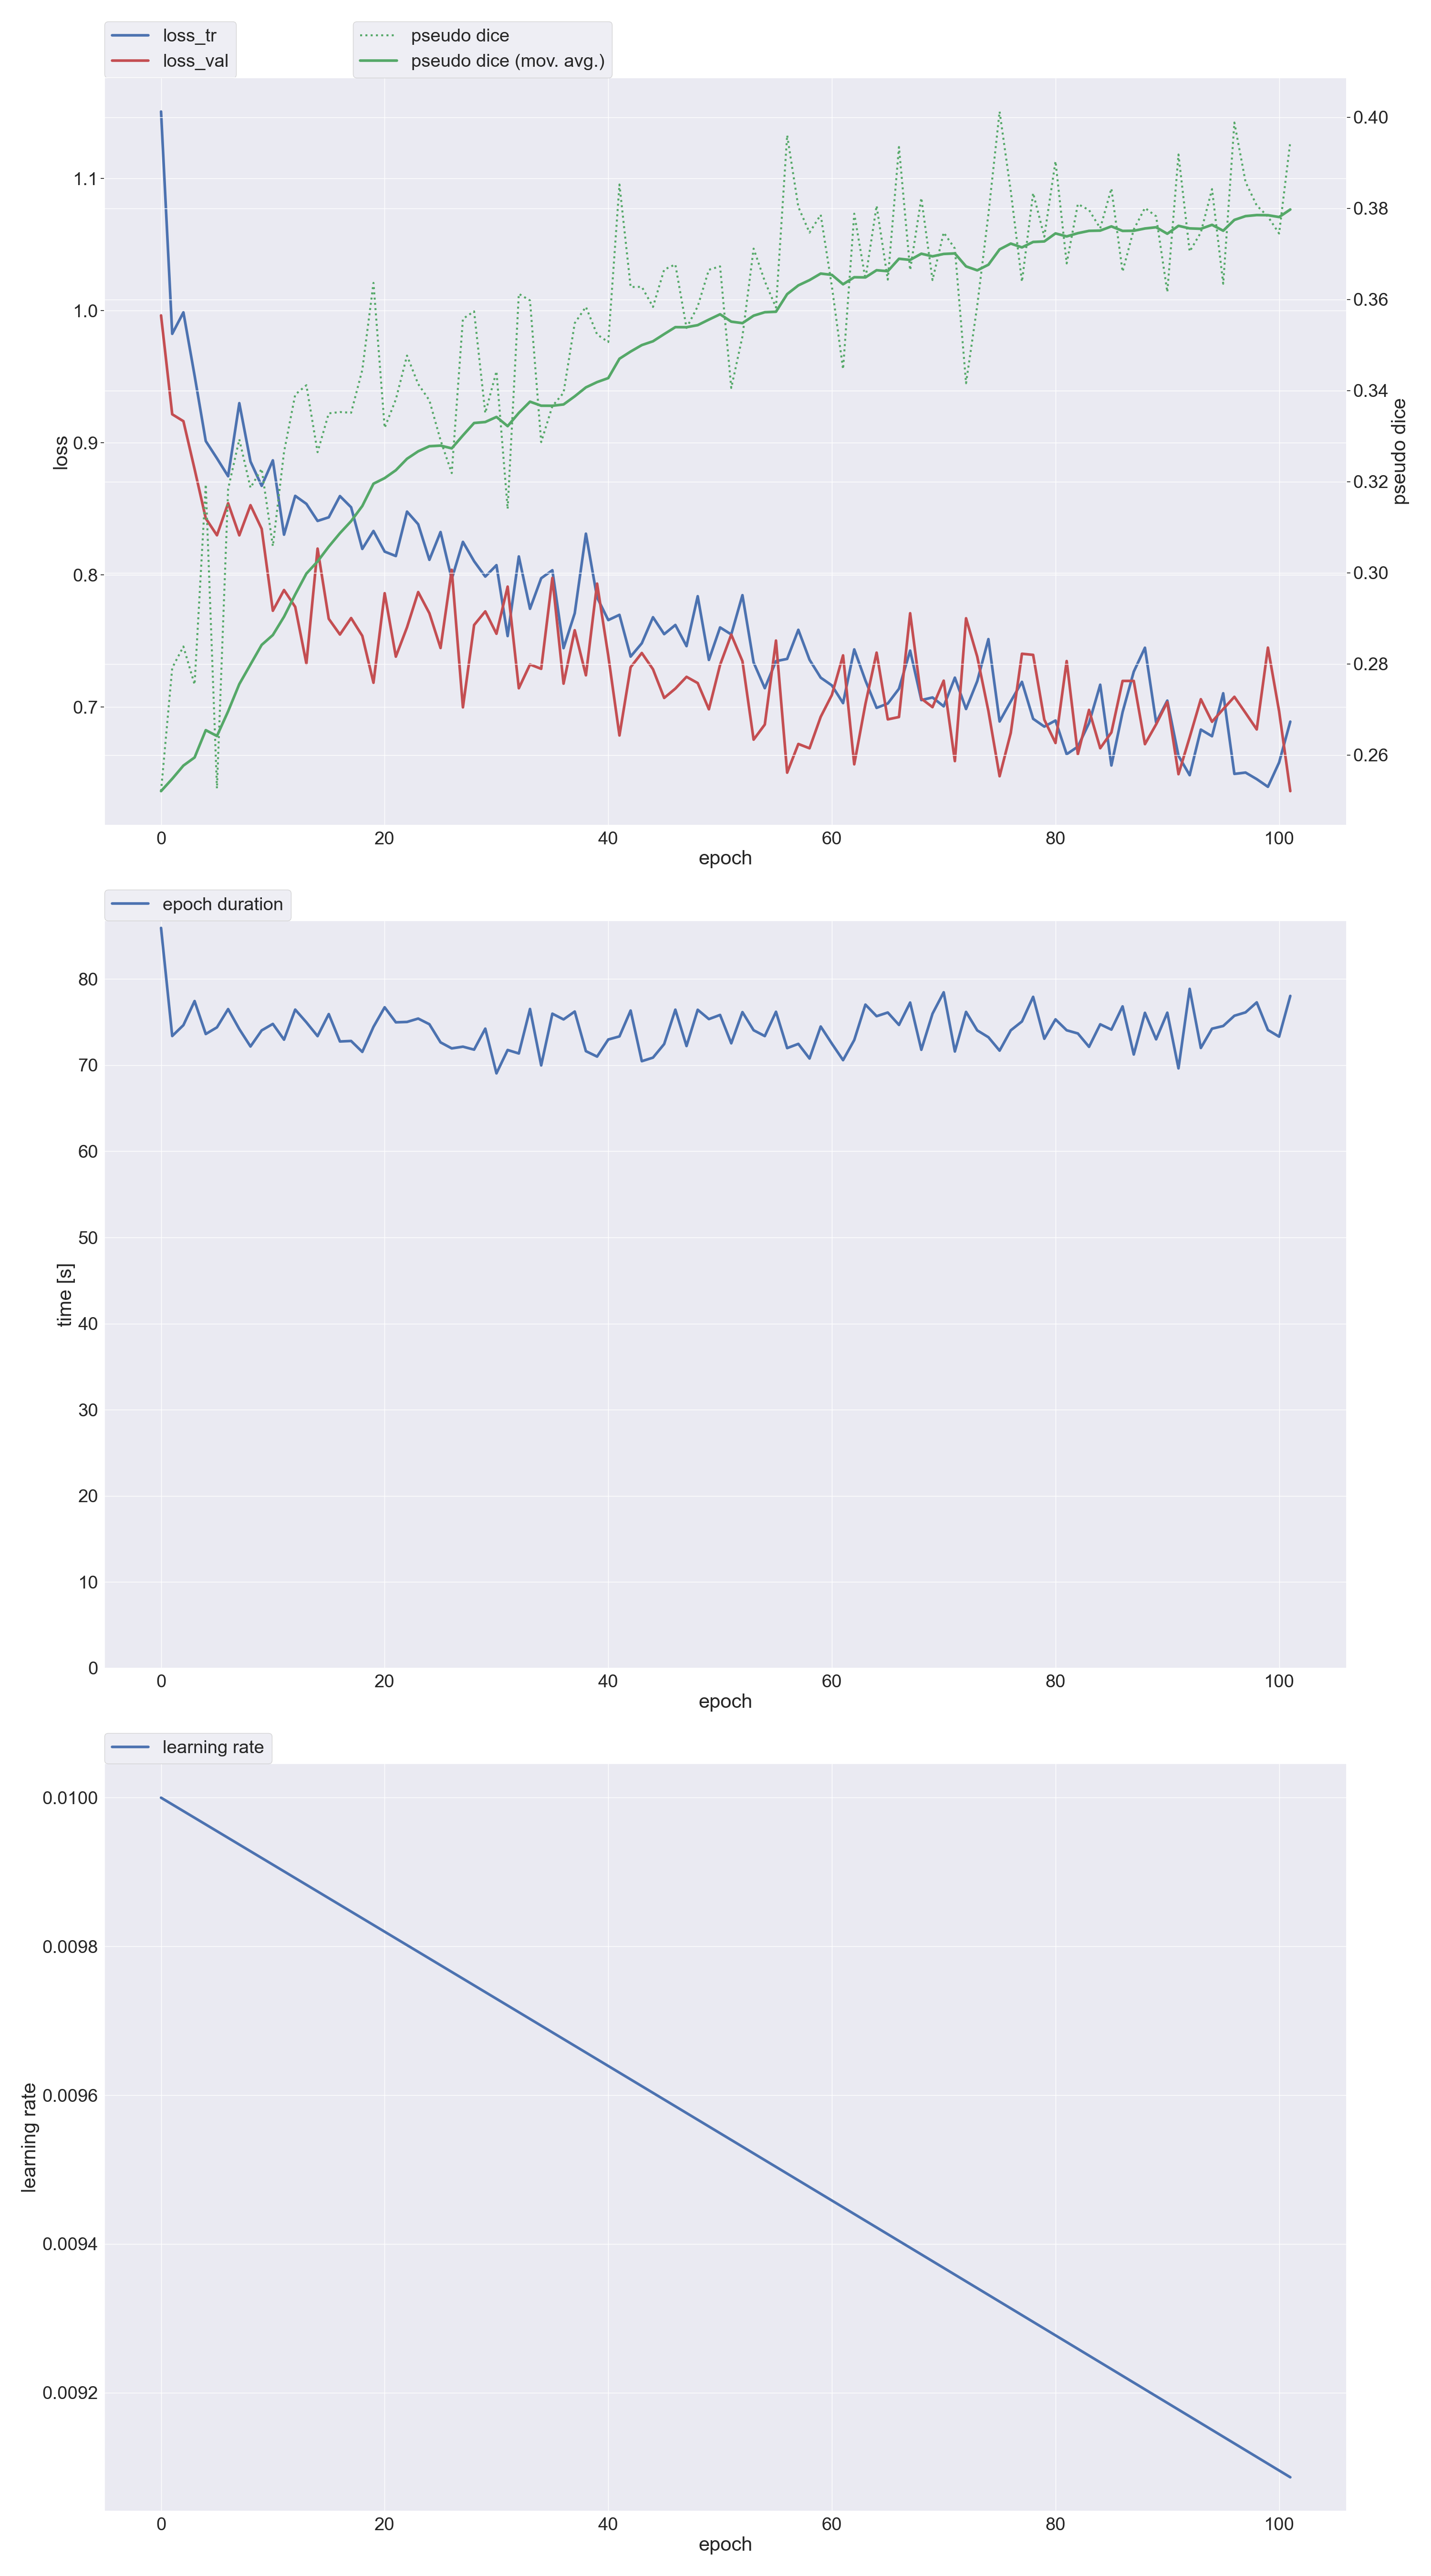

In [7]:
show_progress(rf"D:\nnUNet_results\Dataset045_Perfusion\nnUNetTrainer__nnUNetPlans__3d_fullres\fold_0\progress.png")